In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random



sys.path.append("../functions")

from Forward import simulate_agent, get_subject_task
from multiprocessing import Pool
from scipy.optimize import minimize
from Forward import forward_fitting
from Backward import fit_model_backward 
from Plotting import *


from Utils import *
%matplotlib inline


# 1. Read Task Data

In [3]:
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "hc")
subjects = data["sub"].unique()
n_fitting = 120
n_threads = 100

# 2. Generate Random Params

In [4]:
import numpy as np
import pandas as pd
import random

# Set the random seed for reproducibility
seed = 21
np.random.seed(seed)
random.seed(seed)

# Number of simulations
n_simulation = 100

# Generate parameter lists
params = {
    "agent": np.arange(n_simulation),
    "alpha": np.random.uniform(0, 1, n_simulation),
    "beta": np.random.uniform(0, 100, n_simulation),
    "lbound": np.random.uniform(1, 5, n_simulation),
    "range": np.random.uniform(0, 1, n_simulation),
    "subject": np.random.choice(subjects, size=n_simulation, replace=True)  # Ensure 'subjects' array is defined earlier
}

# Create DataFrame from parameters
params_df = pd.DataFrame(params)

# Calculate 'hbound' based on 'lbound' and 'range'
params_df["hbound"] = (5 - params_df["lbound"]) * params_df["range"] + params_df["lbound"]


# 3. Simulate in the Task with Random Params

In [5]:

def simulate_with_params_one(params_df, data):
    df_lists = []
    for _, row in params_df.iterrows():
        params = [row["alpha"], row["beta"], row["lbound"], row["hbound"]]
        subject = int(row["subject"])
        agent = int(row["agent"])
        trials_info = get_subject_task(data, subject)
        resps, rewards, acc, confs, Q_list = simulate_agent(params, trials_info)
        df = pd.DataFrame({
            "agent": [agent] * len(resps),
            "sub": [subject] * len(resps),
            "run": [0] * len(resps),  # Assuming 'run' is always 0 in this context
            "resp": resps,
            "reward": rewards,
            "cor": acc,
            "cj": confs,
            "Q1": Q_list[:, 0],
            "Q2": Q_list[:, 1]
        })
        df_lists.append(df)
    return pd.concat(df_lists, ignore_index=True)

# Ensure 'params_df' and 'lv_induction_data' are defined before calling
simulate_df = simulate_with_params_one(params_df, data)

# 4. Fit Parameters for Each Agent

In [15]:
def get_task_info(data, agent):
    """Extracts task information for a given agent."""
    one_subject_data = data[data["agent"] == agent]
    return {
        "resp": one_subject_data["resp"].to_numpy(),
        "reward": one_subject_data["reward"].to_numpy(),
        "cj": one_subject_data["cj"].to_numpy()
    }

def fit_for_all_agents(params_ranges, n_threads, n_fitting, agents, data, fitting_func):
    """Fits the model for all agents using multiprocessing."""
    input_dicts = [{
        **get_task_info(data, agent),
        "n_fitting": n_fitting,
        "params_ranges": params_ranges,
        "scale": True
    } for agent in agents]
    with Pool(n_threads) as p:
        results = p.map(fitting_func, input_dicts)
    return results

In [16]:
params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
n_fitting = 120
n_threads = 120

res = fit_for_all_agents(
    params_ranges, n_threads, n_fitting, params["agent"], simulate_df, forward_fitting
)
forward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], params["agent"]
)
forward_df["hbound"] = (5 - forward_df["lbound"]) * (
    forward_df["bound_range"]
) + forward_df["lbound"]

In [18]:
res = fit_for_all_agents(
    params_ranges, n_threads, n_fitting, params["agent"], simulate_df, fit_model_backward
)
backward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], params["agent"]
)
backward_df["hbound"] = (5 - backward_df["lbound"]) * (
    backward_df["bound_range"]
) + backward_df["lbound"]

In [19]:
forward_recovery = params_df.merge(forward_df, left_on= "agent", right_on="subject")
backward_recovery = params_df.merge(backward_df, left_on= "agent", right_on="subject")

# 5. Figures

## Supp Figure 1

(p = 4.40e-69, r = 0.98,ci = [0.97,0.99])
(p = 6.63e-53, r = 0.95,ci = [0.93,0.97])
(p = 2.45e-125, r = 1.00,ci = [1.00,1.00])
(p = 7.93e-118, r = 1.00,ci = [1.00,1.00])


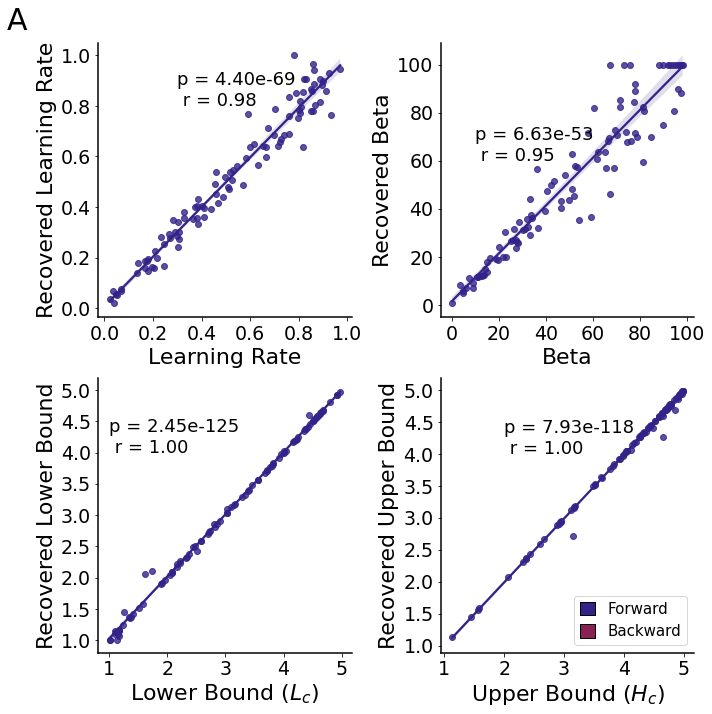

In [23]:
import scipy
import seaborn

from matplotlib.legend_handler import HandlerTuple


fig = plt.figure(figsize=(10, 10))



plt.subplot(2,2,1)
plt.text(-.4, 1.1, "A", fontsize=30)

plot_regression_df(forward_recovery, "alpha_x", "alpha_y", "#332288",0.3, .8, "Learning Rate", "Recovered Learning Rate")


plt.subplot(2,2,2)

plot_regression_df(forward_recovery, "beta_x", "beta_y", "#332288", 10, 60, "Beta","Recovered Beta")


plt.subplot(2,2,3)

plot_regression_df(forward_recovery, "lbound_x", "lbound_y", "#332288", 1, 4, "Lower Bound "+r"$(L_c$)","Recovered Lower Bound")


plt.subplot(2,2,4)

plot_regression_df(forward_recovery, "hbound_x", "hbound_y", "#332288", 2, 4, "Upper Bound "+r"$(H_c$)", "Recovered Upper Bound")

ax = plt.gca()


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

handles = []

handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#332288", edgecolor='black'))
handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#882255", edgecolor='black'))


legend = ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Forward", "Backward"], handlelength=1, handleheight=1,handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower right")
legend._legend_box.align='left'


plt.savefig("../figs/supp_fig1_A.png", dpi=400, bbox_inches='tight')


(p = 4.98e-133, r = 1.00,ci = [1.00,1.00])
(p = 2.27e-129, r = 1.00,ci = [1.00,1.00])
(p = 1.93e-177, r = 1.00,ci = [1.00,1.00])
(p = 1.32e-164, r = 1.00,ci = [1.00,1.00])


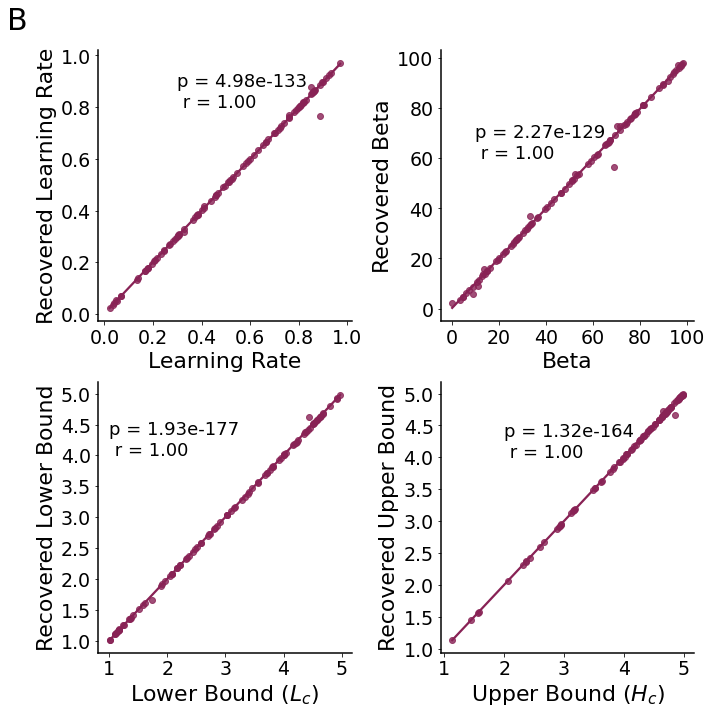

In [26]:
import scipy
import seaborn

from matplotlib.legend_handler import HandlerTuple


fig = plt.figure(figsize=(10, 10))



plt.subplot(2,2,1)
plt.text(-.4, 1.1, "B", fontsize=30)

plot_regression_df(backward_recovery, "alpha_x", "alpha_y", "#882255",0.3, .8, "Learning Rate", "Recovered Learning Rate")


plt.subplot(2,2,2)

plot_regression_df(backward_recovery, "beta_x", "beta_y", "#882255", 10, 60, "Beta","Recovered Beta")


plt.subplot(2,2,3)

plot_regression_df(backward_recovery, "lbound_x", "lbound_y", "#882255", 1, 4, "Lower Bound "+r"$(L_c$)","Recovered Lower Bound")


plt.subplot(2,2,4)

plot_regression_df(backward_recovery, "hbound_x", "hbound_y", "#882255", 2, 4, "Upper Bound "+r"$(H_c$)", "Recovered Upper Bound")


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/supp_fig1_B.png", dpi=400, bbox_inches='tight')


## Supp Figure 2

In [28]:
all_recovery = forward_recovery.merge(backward_recovery, on= "agent")

(p = 2.80e-67, r = 0.98,ci = [0.97,0.98])
(p = 2.05e-53, r = 0.95,ci = [0.93,0.97])
(p = 1.70e-123, r = 1.00,ci = [1.00,1.00])
(p = 3.24e-115, r = 1.00,ci = [1.00,1.00])


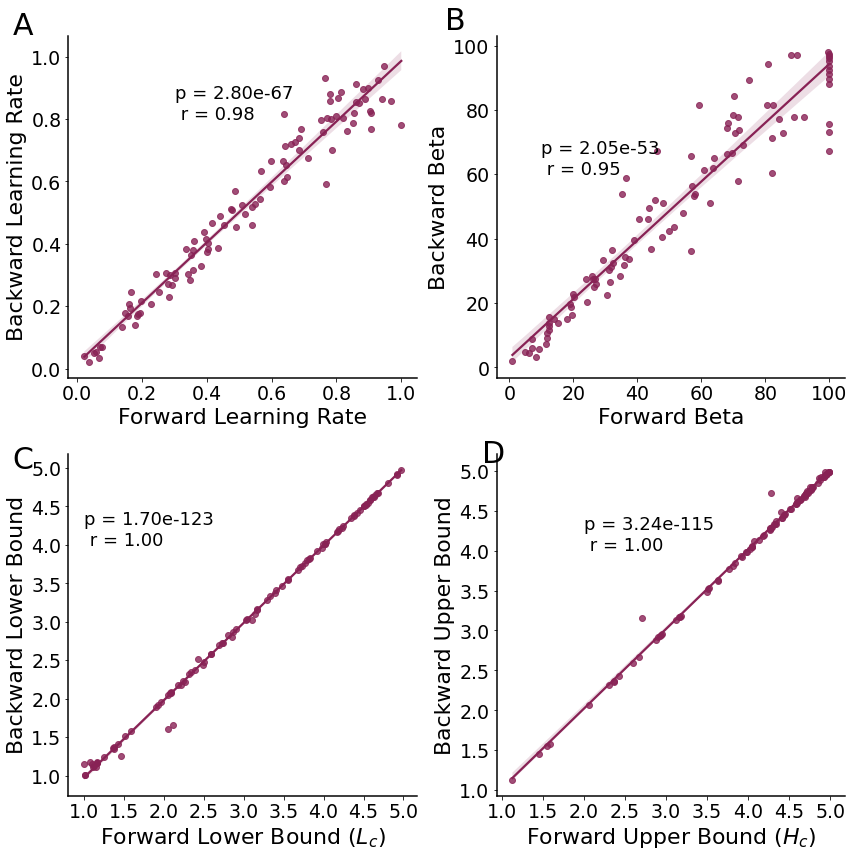

In [30]:
import scipy
import seaborn

from matplotlib.legend_handler import HandlerTuple


fig = plt.figure(figsize=(12, 12))



plt.subplot(2,2,1)
plt.text(-.2, 1.07, "A", fontsize=30)

plot_regression_df(all_recovery, "alpha_y_x", "alpha_y_y", "#882255",0.3, .8, "Forward Learning Rate", "Backward Learning Rate")


plt.subplot(2,2,2)
plt.text(-20, 105, "B", fontsize=30)

plot_regression_df(all_recovery, "beta_y_x", "beta_y_y", "#882255", 10, 60, "Forward Beta","Backward Beta")


plt.subplot(2,2,3)
plt.text(., 5, "C", fontsize=30)

plot_regression_df(all_recovery, "lbound_y_x", "lbound_y_y", "#882255", 1, 4, "Forward Lower Bound "+r"$(L_c$)","Backward Lower Bound")


plt.subplot(2,2,4)

plt.text(.7, 5.1, "D", fontsize=30)

plot_regression_df(all_recovery, "hbound_y_x", "hbound_y_y", "#882255", 2, 4, "Forward Upper Bound "+r"$(H_c$)", "Backward Upper Bound")


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/supp_fig2.png", dpi=400, bbox_inches='tight')
